# Práctica 6: Análisis de Componentes Principales (PCA)
### Autores: Daniel Herce, Javier Tirado Garín, Luis Montesano
### Versión 1.0
### Fecha: 13-04-2024

---

En este template, hay alguna función que requiere `scikit-learn>=1.3`. La siguiente celda <br>
comprueba la versión de `scikit-learn` que está instalada en tu entorno. Si no está esta versión <br>
y se está trabajando en `Google Colab`, la siguiente celda instala la versión necesaria. Si se está <br>
trabajando en local (p. ej. con `conda`), por favor, instala versión necesaria manualmente.

In [33]:
from packaging import version

import sklearn

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    

# sklearn >= 1.3?
sklearn_version = sklearn.__version__
if version.parse(sklearn_version) < version.parse("1.3"):
    if IN_COLAB:
        print("Instalando scikit-learn version >= 1.3. ...")
        %pip uninstall scikit-learn -y
        %pip install -U scikit-learn
    else:
        msg = "Por favor, actualiza manualmente la versión de scikit-learn a >= 1.3 en tu entorno virtual."
        raise ImportError(msg)
else:
    print(f"La versión de scikit-learn ({sklearn_version}) es suficiente (>= 1.3).")

La versión de scikit-learn (1.3.0) es suficiente (>= 1.3).


Como de costumbre, primero importamos las librerías y funciones/clases que emplearemos en la práctica:

In [34]:
from time import perf_counter

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import (
    ValidationCurveDisplay,  # type: ignore
    train_test_split,
)

# descomenta %matplotlib qt si prefieres plots interactivos
%matplotlib inline
# %matplotlib qt

## 0. Carga de datos

En esta práctica vamos a emplear la base de datos [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist). <br>
Su formato es el mismo a *MNIST*, pero en vez dígitos, nuestro objetivo es clasificar prendas de ropa.

En primer lugar, cargamos Fashion-MNIST en la RAM:

In [35]:
# El dataset puede encontrarse en:
# https://github.com/zalandoresearch/fashion-mnist
# Para mayor facilidad, vamos a cargarlo directamente de:
# https://www.openml.org/search?type=data&sort=runs&id=40996&status=active
fashion_mnist = fetch_openml("Fashion-MNIST", parser="pandas")

# numpy ndarrays con las features y el target
X = fashion_mnist.data.values / 255  # (70000, 784=28x28) en [0, 1]
y = fashion_mnist.target.values.astype(int)  # (70000,) en [0, 9]

# el dataset está estructurado de tal forma que las primeras 60.000 instancias
# (imágenes) son de entrenamiento y las últimas 10.000 de test:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=int(1e4), shuffle=False
)

# En Fashion-MNIST, cada valor númerico se corresponde con una prenda. Usaremos el
# siguiente diccionario para el mapeo número -> prenda:
target_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# o si las preferimos recuperar en español:
target_names_esp = {
    0: "Camiseta",
    1: "Pantalón",
    2: "Suéter",
    3: "Vestido",
    4: "Abrigo",
    5: "Sandalia",
    6: "Camisa",
    7: "Zapatilla",
    8: "Bolso",
    9: "Bota",
}

Vamos a explorar brevemente el dataset para hacernos una idea de su contenido:

In [36]:
print("¿Cuántas imágenes de cada prenda hay en el dataset de entrenamiento?:")
print("¿Está balanceado?\N{THINKING FACE}:\n")
unique, counts = np.unique(y_train, return_counts=True)
print(f"{'Prenda':20} #Imágenes")
print("-" * 30)
for u, c in zip(unique, counts):
    print(f"{target_names_esp[u]:25}{c}")

¿Cuántas imágenes de cada prenda hay en el dataset de entrenamiento?:
¿Está balanceado?🤔:

Prenda               #Imágenes
------------------------------
Camiseta                 6000
Pantalón                 6000
Suéter                   6000
Vestido                  6000
Abrigo                   6000
Sandalia                 6000
Camisa                   6000
Zapatilla                6000
Bolso                    6000
Bota                     6000


Vamos a definir una función que nos permita visualizar una muestra de imágenes del dataset:

In [37]:
def visualize_subset_in_grid(
    images,
    labels,
    predicted_labels=None,
    subset=25,
    esp=True,
    random=True,
    ncols=None,
    fig=None,
    ax=None,
):
    """Visualiza un subset de imágenes en una cuadrícula.

    Args:
        images: (n, 784) array con n imágenes 28x28 de Fasion-MNIST.
        labels: (n,) array con las etiquetas (numéricas) de las n imágenes.
        predicted_labels: (n,) array con las etiquetas predichas por un modelo.
        subset: Si es un integer, número de imágenes a visualizar, si es una secuencia
            de enteros, visualiza las imágenes con esos índices.
        esp: Si True, las etiquetas se mostrarán en español.
        random: Si True y subset es un entero, las imágenes se seleccionarán
            aleatoriamente.
        ncols: Número de columnas de la cuadrícula. Si es None, se usará una grid
            cuadrada.
        fig: Figura de matplotlib en la que visualizar las imágenes. Si es None, se
            creará una nueva figura.
        ax: Array de ejes de matplotlib en los que visualizar las imágenes. Si es None,
            se crearán nuevos ejes.
    """
    assert images.shape[1] == 784, "Las imágenes deben ser de 28x28 píxeles."
    assert len(images) == len(labels), "#imagenes debe coincidir con el de labels."

    if isinstance(subset, int):
        if random:
            subset = np.random.choice(images.shape[0], subset, replace=False)
        else:
            subset = np.arange(subset)

    n = len(subset)
    if ncols is None:
        ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    def get_title_and_color(i):
        if predicted_labels is None:
            if isinstance(labels[i], str):
                return labels[i], {"color": "black"}
            else:
                return names[labels[i]], {"color": "black"}

        is_correct = labels[i] == predicted_labels[i]
        symbol = (
            f"\N{HEAVY CHECK MARK}" if is_correct else f"\N{HEAVY MULTIPLICATION X}"
        )
        title = f"{names[labels[i]]}/{names[predicted_labels[i]]} {symbol}"
        color = "green" if labels[i] == predicted_labels[i] else "red"
        return title, {"color": color}

    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    names = target_names_esp if esp else target_names
    for i, axi in zip(subset, ax.ravel()):
        axi.imshow(images[i].reshape(28, 28), cmap="gray")
        axi.set_title(*get_title_and_color(i))
        axi.axis("off")
    fig.tight_layout()

Por cada ejecución de la siguiente celda se visualizan distintas muestras de Fashion-MNIST.

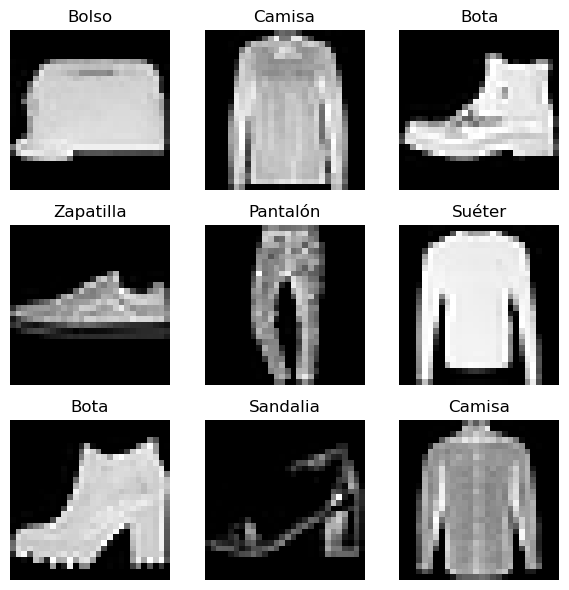

In [38]:
# visualizar un subset de las imágenes
visualize_subset_in_grid(X_train, y_train, subset=9, random=True)

## 1. Preparación de nuestro clasificador (Práctica 5)

Antes de aplicar **PCA** a Fashion-MNIST, a modo de referencia, vamos a crear un <br/>
clasificador Bayesiano "base", tal y como se hizo en la Práctica 5, pero <br/>
particularizándolo a las estadísticas de **Fashion-MNIST**.

Este modelo, entrenado con los datos originales, nos servirá para comparar y comprobar <br/>
la eficacia de **PCA** en la reducción de dimensionalidad.

Primero definimos algunas funciones auxiliares que nos servirán para evaluar los clasificadores...

In [39]:
def evaluar_clasificador(
    clf,
    X_train,
    y_train,
    X_test,
    y_test,
    do_report=True,
    do_cm=True,
    display_labels=None,
):
    """Evaluación de un clasificador.

    Args:
        clf: Clasificador a evaluar.
        X_train, y_train: Conjunto de entrenamiento.
        X_test, y_test: Conjunto de test.
        do_report: Si True, se muestra el report de clasificación.
        do_cm: Si True, se muestra la matriz de confusión.
        display_labels: Nombres de las clases para mostrar en la matriz de confusión.

    Returns:
        Diccionario con los resultados de la evaluación:
            - Tiempo de entrenamiento.
            - Accuracy en el conjunto de entrenamiento.
            - Accuracy en el conjunto de test.
    """
    # tiempo de entrenamiento
    t0 = perf_counter()
    clf.fit(X_train, y_train)
    t1 = perf_counter()
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    if do_cm:
        # matriz de confusión
        cm_display = ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, display_labels=display_labels, xticks_rotation=60.0
        )
        cm_display.ax_.set_title(repr(clf))
    if do_report:
        # report de clasificación
        print(
            classification_report(y_test, y_pred, target_names=display_labels, digits=2)
        )
    # recopilamos algunos resultados para reportarlos en otra función.
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred)
    results = {
        "Tiempo train (sec.)": t1 - t0,
        "Acc. (train)": acc_train,
        "Acc. (test)": acc_test,
    }
    return results


def evaluar_clasificadores(clfs, X_train, y_train, X_test, y_test):
    """Evaluación de varios clasificadores."""
    assert iter(clfs), "clfs debe ser un iterable de clasificadores."
    display_labels = list(target_names_esp.values())
    all_results = {}
    name_mlen = 0
    for clf in clfs:
        name = repr(clf)
        print(f"\n{name}:\n{'-' * (len(name) + 1)}")
        all_results[name] = evaluar_clasificador(
            clf, X_train, y_train, X_test, y_test, display_labels=display_labels
        )
        name_mlen = max(name_mlen, len(name))

    # reporte global de precisión y tiempo de entrenamiento
    headers = [f"{'Modelo':<{name_mlen}}"] + [
        f"{k:>{len(k)}}" for k in all_results[name].keys()
    ]
    print("\n" + "  ".join(headers))
    print("-" * len("  ".join(headers)))
    for name, results in all_results.items():
        row = [f"{name:<{name_mlen}}"] + [
            f"{v:>{len(k)}.2f}" for k, v in results.items()
        ]
        print("  ".join(row))
    print()

La siguiente celda es **opcional** ejecutarla. Esta celda, evalúa uno de los clasificadores propuestos <br> 
en la P5, pero sobre los datos de entrenamiento de Fashion-MNIST. 

En esta Práctica 6, **ya aportamos un clasificador por defecto**. Por tanto, no es necesario <br> 
ejecutar esta celda. Solamente la dejamos por reproducibilidad y mayor claridad. <br>

Empleamos LDA por ser más rápido y proporcionar resultados mejores a Bayes ingenuo y QDA.

Evaluando LDA...


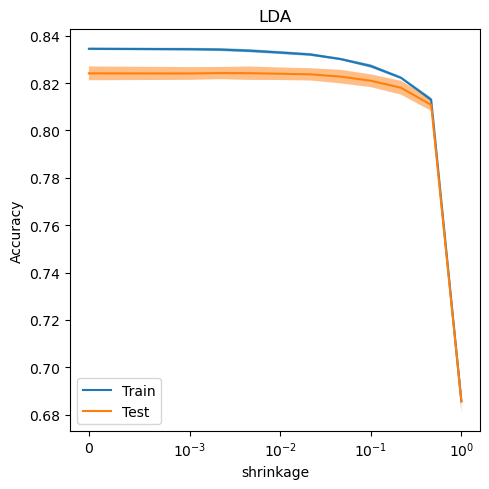

In [8]:
# Configuración para la validación cruzada de cada clasificador.
clasificadores = {
    "LDA": {
        "clf": LinearDiscriminantAnalysis(solver="lsqr"),
        "param_name": "shrinkage",  # (1-shrinkage)*S + (shrinkage*Tr(S)/n)*I_n
        "param_range": np.r_[0.0, np.logspace(-3, 0, 10)],
    }
}

fig, ax = plt.subplots(len(clasificadores), 1, figsize=(5, 5 * len(clasificadores)))
for i, (name, config) in enumerate(clasificadores.items()):
    print(f"Evaluando {name}...")
    ValidationCurveDisplay.from_estimator(
        config["clf"],
        X_train,
        y_train,
        param_name=config["param_name"],
        param_range=config["param_range"],
        scoring="accuracy",
        cv=int(
            len(X_train) / (0.25 * len(X_train))
        ),  # 25% de las imágenes en cada fold
        n_jobs=-1,  # usar todos los cores
        ax=ax,
    )
    ax.set_title(name)
    ax.set_xscale("symlog", linthresh=1e-3)
fig.tight_layout()

Por completitud, añadimos los resultados de test y training para LDA:


LinearDiscriminantAnalysis(shrinkage=0.001, solver='lsqr'):
-----------------------------------------------------------
              precision    recall  f1-score   support

    Camiseta       0.81      0.78      0.79      1000
    Pantalón       1.00      0.93      0.96      1000
      Suéter       0.70      0.68      0.69      1000
     Vestido       0.80      0.84      0.82      1000
      Abrigo       0.70      0.74      0.72      1000
    Sandalia       0.89      0.89      0.89      1000
      Camisa       0.54      0.56      0.55      1000
   Zapatilla       0.88      0.89      0.89      1000
       Bolso       0.93      0.92      0.93      1000
        Bota       0.91      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.82     10000
weighted avg       0.82      0.81      0.82     10000


Modelo                                                      Tiempo train (sec.)  Acc. (train)  Acc. (test)
------------

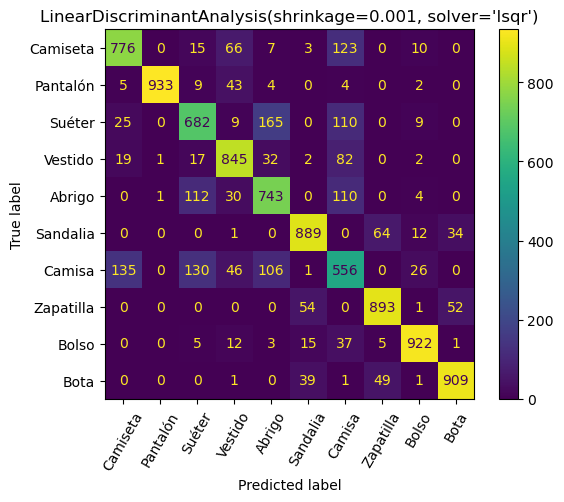

In [9]:
lda = LinearDiscriminantAnalysis(shrinkage=0.001, solver="lsqr")

evaluar_clasificadores([lda], X_train, y_train, X_test, y_test)

La siguiente celda instancia el *clasficador que emplearemos* en el resto de la práctica:

In [10]:
clf = LinearDiscriminantAnalysis(shrinkage=0.001, solver="lsqr")

## 2. Análisis de Componentes Principales (PCA)

Para entender los resultados posteriores, en primer lugar visualiza las (6, por ejemplo) <br> 
componentes **más** y **menos principales**.

Para visualizarlas, te recomendamos emplear la función `visualize_subset_in_grid` <br>
definida anteriormente.

Una vez las visualices, explica por qué crees que dichas componentes principales son así.

In [11]:
# n_components=0.95 significa que se seleccionarán las componentes que expliquen
# el 95% de la varianza total.
# n_components=6 significa que se seleccionarán 6 componentes.
# n_components=None significa que se seleccionarán todas las componentes.
pca = PCA(svd_solver="full")
pca.fit(X_train)

# Guardamos components_ con todas las componentes seleccionadas para que se calcule
# los vectores propios de todas las componentes y así no tener que recalcularlos
# cada vez que se cambie el valor de n_components.
components_completo = pca.components_

In [12]:
def slice_pca(n_components, pca, components_completo, plot=False):
    """Selecciona las primeras n_components componentes de PCA.
        Params:
            n_components: int, número de componentes a seleccionar. Si es negativo, se seleccionan las últimas n_components.
            pca: PCA, instancia de PCA.
            components_completo: ndarray, componentes de PCA con todas las componentes.
            plot: bool, si True, se muestra información sobre la varianza explicada.
    """
    if n_components is None:
        pca.components_ = components_completo
        pca.n_components_ = components_completo.shape[1]
    else:
        if n_components < 0:
            pca.components_ = components_completo[n_components:]
            pca.n_components_ = n_components
            if plot:
                print(f"Se han seleccionado {pca.n_components_} componentes que explican el {pca.explained_variance_ratio_[n_components:].sum()*100:.2f}% de la varianza.")
                print(f"Varianza explicada por cada componente:\n{pca.explained_variance_ratio_[n_components:]}")
                print(f"Varianza explicada acumulada:\n{np.cumsum(pca.explained_variance_ratio_[n_components:])}")
        else:
            pca.components_ = components_completo[:n_components]
            pca.n_components_ = n_components
            if plot:
                print(f"Se han seleccionado {pca.n_components_} componentes que explican el {pca.explained_variance_ratio_[:pca.n_components_].sum()*100:.2f}% de la varianza.")
                print(f"Varianza explicada por cada componente:\n{pca.explained_variance_ratio_[:pca.n_components_]}")
                print(f"Varianza explicada acumulada:\n{np.cumsum(pca.explained_variance_ratio_[:pca.n_components_])}")
        
    return pca

Resulta interesante que las dos primeras componentes principales ya explican aproximadamente <br>
el 46% de la varianza total.

Seleccionando las primeras 6 componentes de PCA:
------------------------------------------------------------
Se han seleccionado 6 componentes que explican el 65.08% de la varianza.
Varianza explicada por cada componente:
[0.29039228 0.1775531  0.06019222 0.04957428 0.03847655 0.03460769]
Varianza explicada acumulada:
[0.29039228 0.46794538 0.5281376  0.57771188 0.61618843 0.65079612]
Dimensionalidad reducida de X_train: (60000, 6)
Dimensionalidad reducida de X_test: (10000, 6)


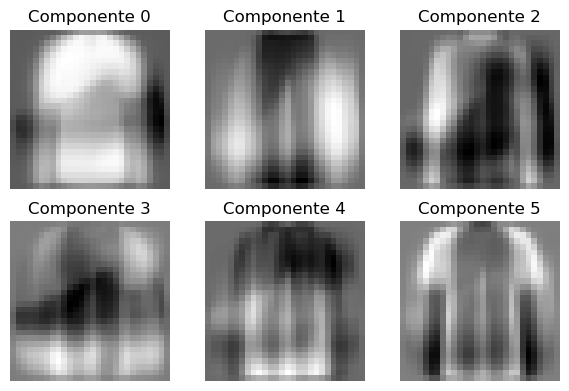

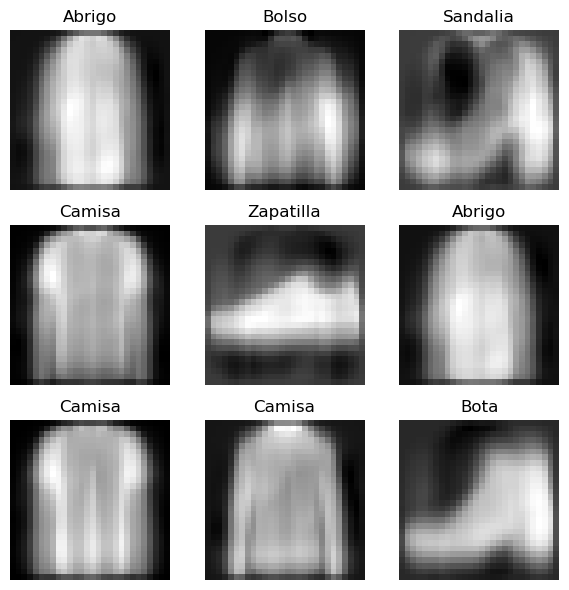

In [13]:
print("Seleccionando las primeras 6 componentes de PCA:")
print("-" * 60)

pca = slice_pca(6, pca, components_completo, True)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Dimensionalidad reducida de X_train: {X_train_pca.shape}")
print(f"Dimensionalidad reducida de X_test: {X_test_pca.shape}")

# Como los vectores propios de PCA son ortogonales y tienen el mismo número de
# dimensiones que las imágenes originales, podemos visualizarlos como imágenes.
visualize_subset_in_grid(pca.components_, [(f'Componente {i}') for i in range(0,6)], subset=6, random=False)

# Visualizamos las imágenes originales y las reducidas a 6 dimensiones.
visualize_subset_in_grid(pca.inverse_transform(X_train_pca), y_train, subset=9, random=True)

Visualizando las componentes principales, podemos ver que las primeras componentes principales <br>
se corresponden con las características más generales de las imágenes, es decir, aquellas que <br>
son más comunes en todas las prendas de ropa (por ejemplo, la forma de la prenda, la presencia <br>
de rayas, etc.). Por otro lado, las últimas componentes principales se corresponden con las <br>
características más específicas de las imágenes, es decir, aquellas que son menos comunes en <br>
todas las prendas de ropa (por ejemplo, la presencia de un estampado concreto, la forma de un <br>
bolsillo, etc.).

Valores altos en las primeras componentes principales indican que la imagen es más "genérica" <br>
y valores altos en las últimas componentes principales indican que la imagen es más "específica".

Esta es la explicación de por qué la primera componente principal define la forma de una prenda <br>
superior, la siguiente se centra en la voluminosidad de las mangas...


Las componenetes están mostrando los valores de un vector, las zonas blancas son los valores en sentido positivo del vector y las negras en sentido negativo, es decir, componente 0 vemos que en su sentido positivo están las camisetas y en el negativo las zapatillas, en la 1 los componentes con mangas son opuestos a los pantalones...

Entonces cuando hagamos predicciones con esas primeras componentes situaremos la imagen en el espacio vectorial definido por esas componentes y la prenda que más cerca esté será la que se prediga.

Por eso al ver las imágenes en el espacio de las componentes principales vemos la silueta de la prenda y otra silueta en oscuro que se corresponde con la prenda opuesta a la que se está mostrando. Por ejemplo en la zapatilla vemos que esta está en blanco y de fondo se aprecia la camiseta en negro.


Seleccionando las últimas 6 componentes de PCA:
------------------------------------------------------------
Se han seleccionado -6 componentes que explican el 0.00% de la varianza.
Varianza explicada por cada componente:
[1.09044842e-07 1.06440821e-07 7.16470997e-08 2.28762700e-08
 8.04734568e-09 1.47383156e-09]
Varianza explicada acumulada:
[1.09044842e-07 2.15485663e-07 2.87132763e-07 3.10009033e-07
 3.18056378e-07 3.19530210e-07]
Dimensionalidad reducida de X_train: (60000, 6)
Dimensionalidad reducida de X_test: (10000, 6)


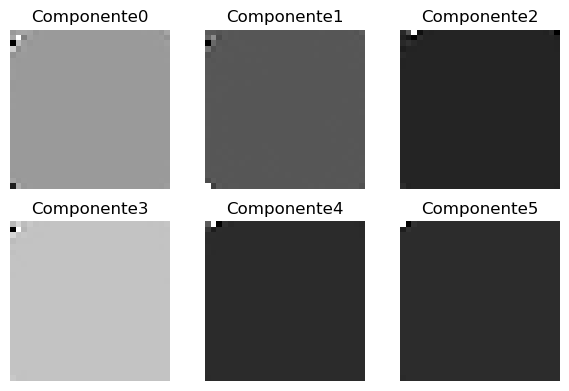

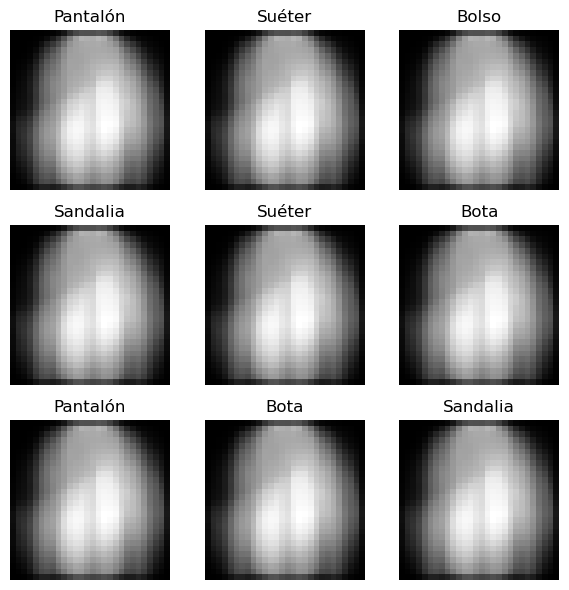

In [14]:
print("Seleccionando las últimas 6 componentes de PCA:")
print("-" * 60)

pca = slice_pca(-6, pca, components_completo, True)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Dimensionalidad reducida de X_train: {X_train_pca.shape}")
print(f"Dimensionalidad reducida de X_test: {X_test_pca.shape}")

# visualizar un subset de las imágenes
visualize_subset_in_grid(pca.components_, [(f'Componente{i}') for i in range(0,6)], subset=6, random=False)

# Visualizamos las imágenes originales y las reducidas a 6 dimensiones.
visualize_subset_in_grid(pca.inverse_transform(X_train_pca), y_train, subset=9, random=True)


Las últimas componentes de pca, las que menos varianza explican son aquellas que se centran en <br>
detalles muy específicos de las imágenes, por eso en este caso salen unos pocos píxeles pintados <br>
y en las imágenes no se aprecia nada en concreto. La imagen mostrada es la imagen media

### 2.1 a) ¿Con cuántas de las 784 componentes te puedes quedar sin alterar los resultados de la clasificación?

Para contestar este apartado te recomendamos emplear la función `evaluar_clasificador` <br>
definida anteriormente.

Explica los resultados obtenidos.

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1000
           1       1.00      0.93      0.96      1000
           2       0.70      0.68      0.69      1000
           3       0.80      0.84      0.82      1000
           4       0.70      0.74      0.72      1000
           5       0.89      0.89      0.89      1000
           6       0.54      0.56      0.55      1000
           7       0.88      0.89      0.89      1000
           8       0.93      0.92      0.93      1000
           9       0.91      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.82     10000
weighted avg       0.82      0.81      0.82     10000



{'Tiempo train (sec.)': 1.8561889000120573,
 'Acc. (train)': 0.8322666666666667,
 'Acc. (test)': 0.8148}

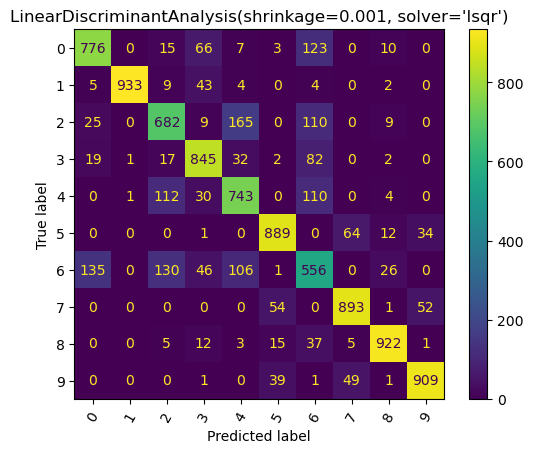

In [15]:
# Evaluamos el modelo para tener una referencia de su rendimiento.
evaluar_clasificador(clf, X_train, y_train, X_test, y_test)

La precisión del modelo con los datos originales es de 0.8148, haciendo PCA no se puede superar <br>
este valor y no se puede igualar a no ser que se añadan todas las componentes.

Es por esto que para que tenga sentido este apartado entenderémos que 0.8100 es el valor a igualar para <br>
entender que "no se alteran los resultados de la clasificación".

In [16]:
# Construiremos una gráfica en la que probaremos la evolución de la precisión del modelo
# en función del número de componentes seleccionadas.
n_components = np.linspace(1, 784, 50, dtype=int)
train_scores = []
test_scores = []
for n in n_components:
    pca = slice_pca(n, pca, components_completo)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf.fit(X_train_pca, y_train)
    train_scores.append(clf.score(X_train_pca, y_train))
    test_scores.append(clf.score(X_test_pca, y_test))

Con 112 componentes, la precisión en train es >= 0.81.
Con 208 componentes, la precisión en test es >= 0.81.


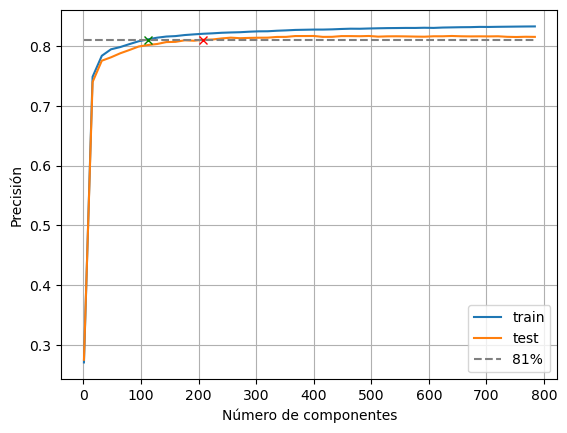

In [17]:
# Guardamos los puntos en los que la precisión en test es mayor o igual al 0.81
n_comp_0_81_train = n_components[np.argmax(np.array(train_scores) >= 0.81)]
n_comp_0_81_test = n_components[np.argmax(np.array(test_scores) >= 0.81)]
print(f"Con {n_comp_0_81_train} componentes, la precisión en train es >= 0.81.")
print(f"Con {n_comp_0_81_test} componentes, la precisión en test es >= 0.81.")


plt.plot(n_components, train_scores, label="train")
plt.plot(n_components, test_scores, label="test")
plt.plot(n_components, [0.81] * len(n_components), "--", color="gray", label="81%")

plt.plot(n_comp_0_81_train, 0.81, "x", color="green")
plt.plot(n_comp_0_81_test, 0.81, "x", color="red")

plt.xlabel("Número de componentes")
plt.ylabel("Precisión")
plt.legend()
plt.grid()
plt.show()


Podemos quedarnos con 208 y la precisión en test es mayor o igual a 0.81

### 2.1 b) Si reduces las dimensiones de los datos para mantener el 99% de la variabilidad, ¿qué tan buenos son los resultados de la clasificación?

Comenta los resultados, compara con los obtenidos sin aplicar PCA (ya aportados en este template) <br>
y con los que has obtenido en la pregunta anterior.

In [18]:
# Para reducir la dimensionalidad de los datos hasta mantener el 99% de la varianza
# volveremos a hacer pca con n_components=0.99.
pca = PCA(n_components=0.99, svd_solver="full")
pca.fit(X_train)
X_train_pca = pca.transform(X_train) # (60000, n_components)
X_test_pca = pca.transform(X_test)  # (10000, n_components)

print(f"Dimensionalidad reducida de X_train: {X_train_pca.shape}")
print(f"Dimensionalidad reducida de X_test: {X_test_pca.shape}")

Dimensionalidad reducida de X_train: (60000, 459)
Dimensionalidad reducida de X_test: (10000, 459)


              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1000
           1       1.00      0.93      0.96      1000
           2       0.71      0.69      0.70      1000
           3       0.81      0.84      0.83      1000
           4       0.70      0.75      0.73      1000
           5       0.89      0.89      0.89      1000
           6       0.55      0.56      0.55      1000
           7       0.89      0.89      0.89      1000
           8       0.93      0.93      0.93      1000
           9       0.91      0.92      0.91      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



{'Tiempo train (sec.)': 0.667704200008302,
 'Acc. (train)': 0.8283,
 'Acc. (test)': 0.8164}

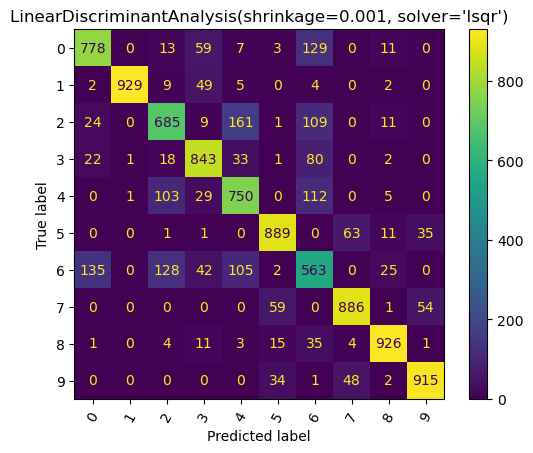

In [19]:
evaluar_clasificador(clf, X_train_pca, y_train, X_test_pca, y_test)

El modelo original tenía una precisión en test de 0.8148, con PCA y las 208 componentes que explican <br>
el 99% de la varianza, la precisión en test es de 0.8164, por lo que se ha mejorado ligeramente el <br>
modelo.

Esto se debe a que las componentes que se han eliminado no aportaban información relevante para la <br>
clasificación de las imágenes, por lo que se ha mejorado el modelo al eliminar ruido. Es un modeo más <br>
simple y generalizable, las componentes que tiene que ajustar las ajusta mejor.



### 2.1 c) Reconstruye alguna imagen del dataset de entrenamiento.

Cualitativamente, podemos comprobar la información retenida por las componentes, <br>
reconstruyendo las imágenes desde el espacio de dimensionalidad reducida, y de forma <br>
cuantitativa, mediante la métrica [***PSNR***](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) (*Peak Signal-to-Noise Ratio*).

Puedes utilizar la función `calculate_psnr`, definida a continuación, para calcular el [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) <br> 
de un conjunto de imágenes reconstruidas respecto a las originales. 

Para comparar visualmente las imágenes reconstruidas, te recomendamos completar la función <br> 
`show_reconstruction_vs_ncomponents`.

In [20]:
def calculate_psnr(imgs, reconstructed_imgs):
    """Peak Signal-to-Noise Ratio (PSNR) para batch de imágenes.

    Args:
        imgs: (n, d) array con n imágenes 28x28.
        reconstructed_imgs: (n, d) array con las imágenes reconstruidas.

    Returns:
        psnr: (n,) array con el PSNR de cada imagen reconstruida.
    """
    mse = np.mean((imgs - reconstructed_imgs) ** 2, axis=1)
    psnr = np.empty_like(mse)
    mask = mse == 0
    psnr[mask] = np.inf
    R2 = 1.0 if imgs.max() <= 1 + 1e-9 else 255**2  # rango de los píxeles
    psnr[~mask] = 10 * np.log10(R2 / mse[~mask])
    return psnr


def show_reconstruction_vs_ncomponents(X, n_components=None, idx=None):
    """Reconstruye y visualiza una imagen a partir de sus componentes principales.

    Esta función debería crear una figura con `nc` subplots, donde `nc` es el número de
    componentes principales a usar para la reconstrucción (ver Args).

    Args:
        X: (n, d) array con n imágenes y dimensión d=28*28=784.
        n_components: (nc,) array con el número de componentes (más) principales a usar
            para la reconstrucción.
            Por ejemplo, `n_components`=[10, 22, 35] correspondería a 3 subplots:
                - subplot 1: reconstrucción usando 10 PCs,
                - subplot 2: reconstrucción usando 22 PCs,
                - subplot 3: reconstrucción usando 35 PCs.
        idx: (int) Índice de la imagen a reconstruir.
    """
    if n_components is None:
        n_components = np.linspace(10, X.shape[1], 5).astype(int)
    if idx is None:
        idx = np.random.choice(len(X))

    fig, ax = plt.subplots(1, len(n_components) + 1, figsize=(3 * (len(n_components) + 1), 3))

    # imagen original
    ax[0].imshow(X[idx].reshape(28, 28), cmap="gray")   # Mostramos la imagen original
    ax[0].set_title("Original")
    ax[0].axis("off")   # Quitamos los ejes


    pca = PCA(svd_solver="full").fit(X)
    components_completo = pca.components_

    for i, nc in enumerate(n_components, 1):
        pca = slice_pca(nc, pca, components_completo, plot=False)   # Seleccionamos las primeras `nc` componentes
        
        # Reconstruimos la imagen, primero transformamos la imagen original a las componentes principales
        # y luego la reconstruimos a partir de estas componentes.
        X_reconstructed = pca.inverse_transform(pca.transform(X[[idx]]))
        psnr = calculate_psnr(X[[idx]], X_reconstructed)
        ax[i].imshow(X_reconstructed.reshape(28, 28), cmap="gray")
        ax[i].set_title(f"{nc} PCs, PSNR: {psnr[0]:.2f} dB")
        ax[i].axis("off")

    fig.tight_layout()



Ejemplo de resultado (recuerda completar `show_reconstruction_vs_ncomponents`):

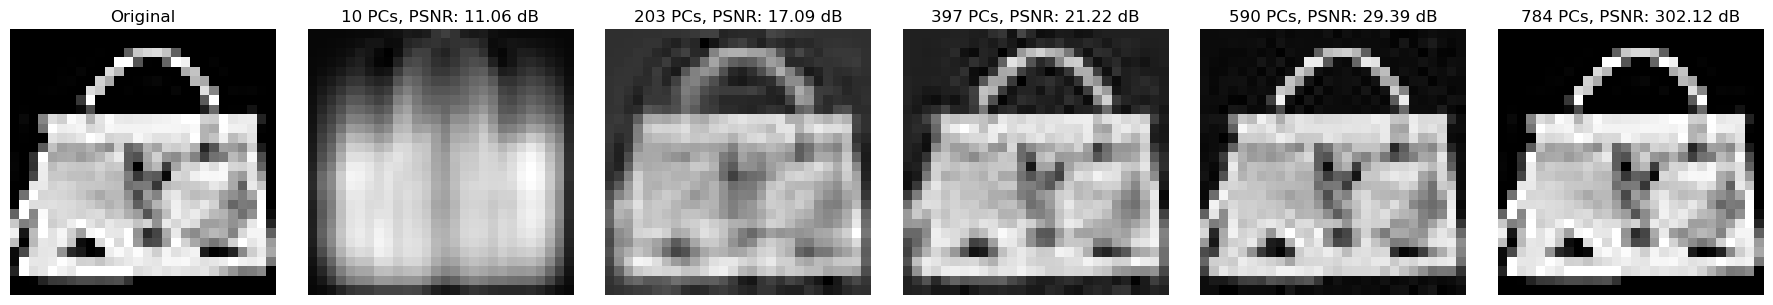

In [21]:
idx = None
n_components = np.linspace(10, X_train.shape[1], 5).astype(int)
show_reconstruction_vs_ncomponents(X_train, n_components, idx)

Podemos observar como conforme se utilizan más componentes para reconstruir la imagen, <br>
la calidad de la reconstrucción mejora. Sin embargo, tal y como ya hemos comentado, la mejora <br>
es significativa al principio, a partir de las 208 componentes ya se explica el 99% de la varianza <br>
por lo que la mejora es mínima a partir de dicho punto donde solo se oscurece el fondo.



Es llamativo que el PSNR mejora levemente al principio teniendo valores menores a 50db <br>
en las primeras reconstrucciones y al añadir el último tramo de componentes este mejora a más de 300db.

Para ver su evolución veremos la siguiente gráfica:

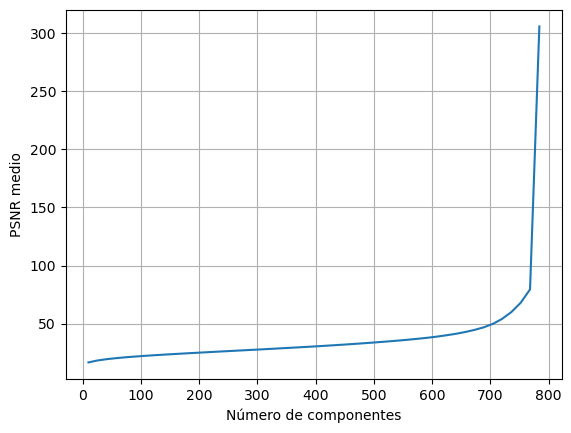

In [22]:
pca = PCA(svd_solver="full").fit(X_train)
components_completo = pca.components_

pnsr_values = []
nc_values = np.linspace(10, X_train.shape[1], 50, dtype=int)
for nc in nc_values:
    pca = slice_pca(nc, pca, components_completo, plot=False)   # Seleccionamos las primeras `nc` componentes
    img_reconstructed = pca.inverse_transform(pca.transform(X_train))
    pnsr_values.append(calculate_psnr(X_train, img_reconstructed).mean())


plt.plot(nc_values, pnsr_values)
plt.xlabel("Número de componentes")
plt.ylabel("PSNR medio")
plt.grid()
plt.show()

Tal y como se había observado, el psnr crece paulatinamente hasta las 700 componentes, <br>
donde tiene un valor de 50dB y a partir de ahí crece de forma exponencial.

El comportamiento observado con el aumento abrupto del PSNR más allá de cierto número de <br>
componentes en PCA probablemente refleje el fenómeno de convergencia hacia la reconstrucción <br>
casi perfecta de las imágenes originales a medida que se utilizan más componentes principales <br>
para la representación. 

Esto muestra que un aumento en el psnr a partir de un número de componentes elevado no es tán relevante <br>
ya que visualmente no hay una gran diferencia.

### 2. Filtrado de ruido en imágenes.

En esta última parte, vamos a analizar la utilidad de PCA para filtrar ruido Gaussiano en imágenes.

In [23]:
def add_noise_to_images(X, noise_std):
    """Añade ruido Gaussiano (centrado en 0) de magnitud `noise_std` a las imágenes ."""
    return np.clip(X + noise_std * np.random.randn(*X.shape), 0, 1)

El siguiente widget visualiza de forma interactiva como afecta el ruido a las imágenes de <br>
Fashion-MNIST, para diferentes valores de `noise_std`:

In [24]:
ncols = 3
subset = np.random.choice(len(X_train), 12, replace=False)
nrows = int(np.ceil(len(subset) / ncols))


@widgets.interact(noise_level=(0, 0.5, 0.01))
def display_images(noise_level=0.3):
    images = X_train[subset]
    images = add_noise_to_images(images, noise_level)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5))
    visualize_subset_in_grid(
        images, y_train[subset], subset=len(subset), fig=fig, ax=ax, random=False
    )
    plt.show()

interactive(children=(FloatSlider(value=0.3, description='noise_level', max=0.5, step=0.01), Output()), _dom_c…

La siguiente celda controla el ruido añadido al dateset mediante `noise_std`:

In [25]:
noise_std = 0.3
X_train_noisy = add_noise_to_images(X_train, noise_std=noise_std)
X_test_noisy = add_noise_to_images(X_test, noise_std=noise_std)

#### 2. a) Utiliza PCA para eliminar el ruido de las imágenes.

En la siguiente celda, visualizamos de forma interactiva el *PSNR* de **todas** las imágenes reconstruidas <br>
con PCA, en función del número de componentes principales indicadas con el slider `n_components`. 

También se visualiza el filtrado de ruido para una imagen de forma interactiva <br> 
(seleccionada con el slider `idx`).

In [26]:
pca_full = PCA()
pca_full.fit(X_train_noisy)
components_full = pca_full.components_  # (n_components, 784)
# reference PSNR values.
psnr_noisy = calculate_psnr(X_train, X_train_noisy)
min_noisy = np.min(psnr_noisy)
max_noisy = np.max(psnr_noisy)


@widgets.interact(n_components=(4, 784, 10), idx=(0, len(X_train_noisy), 1))
def show_reconstruction_vs_ncomponents(n_components=784, idx=0):
    """Visualización interactiva del filtrado de ruido con PCA."""
    # Monkey-patching para evitar calcular de nuevo los componentes principales.
    pca_full.components_ = components_full[:n_components]
    # imágenes filtradas con PCA y sus correspondientes PSNR.
    X_recon = pca_full.inverse_transform(pca_full.transform(X_train_noisy))

    psnr_pca = calculate_psnr(X_train, X_recon)  # (n,)
    binwidth = 0.1
    bins = np.arange(
        min(min_noisy, np.min(psnr_pca)),
        max(max_noisy, np.max(psnr_pca)) + binwidth,
        binwidth,
    )
    # visualización
    fig, ax = plt.subplots(2, 2, figsize=(5, 5))
    ax[0, 0].imshow(X_train[idx].reshape(28, 28), cmap="gray")
    ax[0, 0].set_title("Original")
    ax[0, 1].imshow(X_train_noisy[idx].reshape(28, 28), cmap="gray")
    ax[0, 1].set_title("Ruidosa")
    ax[1, 0].imshow(X_recon[idx].reshape(28, 28), cmap="gray")
    ax[1, 0].set_title("Filtrada")
    # psnr histograms
    ax[1, 1].hist(psnr_noisy, bins=bins, alpha=0.5, label="Ruidosa")
    ax[1, 1].hist(psnr_pca, bins=bins, alpha=0.5, label="Filtrada")
    ax[1, 1].set_xlabel("PSNR")
    ax[1, 1].legend()
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=784, description='n_components', max=784, min=4, step=10), IntSlider(val…

Modifica los niveles de ruido (`noise_std`) y utiliza el widget para explicar el comportamiento de <br>
PCA.

Para explicarlo, te recomendamos comparar los valores singulares, con y sin ruido (accesibles con el <br>
atributo [`singular_values_`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#:~:text=equal%20to%201.0.-,singular_values_,-ndarray%20of%20shape)) 
o visualizando, para las imágenes ruidosas, la curva con: <br> 
(eje y) error de reconstrucción o PSNR, (eje x) número de componentes empleados en la reconstrucción.

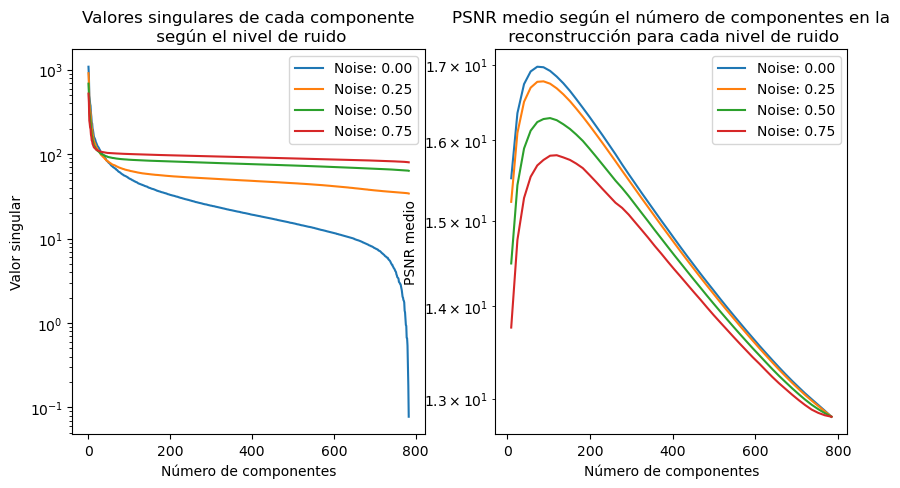

In [40]:
noise_values = [0, 0.25, 0.5, 0.75]

# Vamos a hacer 2 gráficas, una con los valores singulares en función de la cantidad de ruido
# y otra con el PSNR con las diferentes cantidades de ruido en función del número de componentes utilizados
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
pca = PCA()

for noise in noise_values:
    pca.fit(add_noise_to_images(X_train, noise))

    # Singular values
    ax[0].plot(pca.singular_values_, label=f"Noise: {noise:.2f}")


    # PSNR
    psnr_values = []
    nc_values = np.linspace(10, X_train.shape[1], 50, dtype=int)
    for nc in nc_values:
        pca = slice_pca(nc, pca, components_completo, plot=False)   # Seleccionamos las primeras `nc` componentes
        img_reconstructed = pca.inverse_transform(pca.transform(X_train_noisy))
        psnr_values.append(calculate_psnr(X_train, img_reconstructed).mean())

    
    ax[1].plot(nc_values, psnr_values, label=f"Noise: {noise:.2f}")


ax[0].set_title("Valores singulares de cada componente\n según el nivel de ruido")
ax[0].set_xlabel("Número de componentes")
ax[0].set_ylabel("Valor singular")
ax[0].grid()
ax[0].set_yscale("log")
ax[0].legend()


ax[1].set_title("PSNR medio según el número de componentes en la\n reconstrucción para cada nivel de ruido")
ax[1].set_xlabel("Número de componentes")
ax[1].set_ylabel("PSNR medio")
ax[0].grid()
ax[1].set_yscale("log")
ax[1].legend()

plt.show()




Para entender estas gráficas lo primero que hay que entender es qué es el ruido. <br>
Añadir ruido es simplemente añadir una señal aleatoria a la imagen original, lo que <br>
en la práctica se traduce en sumar a cada píxel un valor aleatorio que multiplicas por <br>
el valor de `noise_std`. (En este caso es ruido positivo)

Esto provoca que los valores singulares sean mayores, ya que la imagen original se ha <br>
desplazado hacia arriba, por lo que los valores singulares también lo harán. Otra <br>
consecuencia de añadir ruido es que la diferencia entre los valores propios sea <br>
menor ya que resulta más complicado encontrar correlaciones claras entre píxeles debido <br>
al ruido.

Esto se ve claramente en la primera gráfica donde se observa que cuanto mayor es el <br>
nivel de ruido menos decrece el valor del valor singular según el número de componentes.


Con el widget se puede comporbar como el ruido empeora la calidad de las imágenes y como <br>
filtrando con pca estas se van difuminando conforme se reducen el número de componentes <br>
de forma que con un numero bajo de componentes se aprecia la forma de la prenda sin estar <br>
difuminada excesivamente. Este número de componentes que permite eliminar el suficiente <br>
ruido como para identificar la prenda sin que esta esté muy difuminada o se quede una imagen <br>
sin apenas información coincide con el punto en el que las componentes estabilizan su valor singular.

Esto demuestra como PCA hace un buen trabajo filtrando en las primeras componentes principales <br>
aquellas que sirven para describir la ropa y no el ruido, por lo que el PSNR alcanza su máximo con <br>
las primeras componentes y a partir de ahí empeora ya que las dimensiones añadidas son las que <br>
explican el ruido y no la prenda.

#### 2. c) Evalúa el clasificador Bayesiano en imágenes de test ruidosas y en el espacio PCA

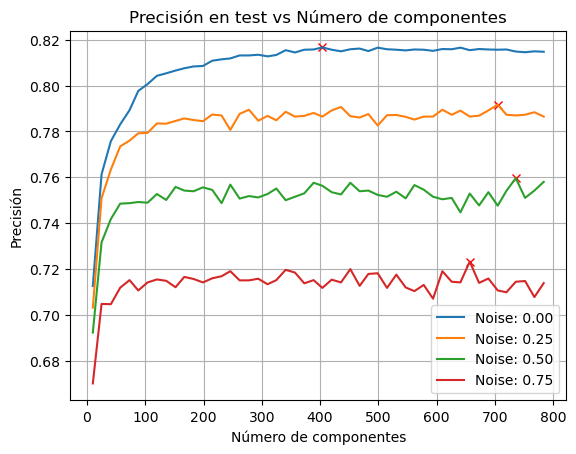

In [28]:
noise_values = [0, 0.25, 0.5, 0.75]

plt.figure()
pca = PCA()

for noise in noise_values:
    #Entrenamos el clasificador con el ruido
    pca.fit(add_noise_to_images(X_train, noise))

    # Evaluamos el clasificador solo teniendo en cuenta nc componentes
    train_scores = []
    test_scores = []
    nc_values = np.linspace(10, X_train.shape[1], 50, dtype=int)
    for nc in nc_values:
        pca = slice_pca(nc, pca, components_completo, plot=False)   # Seleccionamos las primeras `nc` componentes
        X_train_pca = pca.transform(add_noise_to_images(X_train, noise))
        X_test_pca = pca.transform(add_noise_to_images(X_test, noise))
        clf.fit(X_train_pca, y_train)
        train_scores.append(clf.score(X_train_pca, y_train))
        test_scores.append(clf.score(X_test_pca, y_test))

    # Pintamos el punto donde se obtiene la mayor precision en test
    max_test_score = max(test_scores)
    nc_max_test_score = nc_values[np.argmax(test_scores)]
    plt.plot(nc_max_test_score, max_test_score, "x", color="red")
    plt.plot(nc_values, test_scores, label=f"Noise: {noise:.2f}")

plt.xlabel("Número de componentes")
plt.ylabel("Precisión")
plt.title("Precisión en test vs Número de componentes")
plt.grid()
plt.legend()
plt.show()


Explica de forma razonada los resultados y las decisiones tomadas.

Podemos observar como cuanto mayor es la cantidad de ruido menor es la precisión del modelo, <br>
esto se debe a que el ruido añadido a las imágenes de test hace que estas sean más difíciles <br>
de clasificar, ya que no puede aprender bien la forma de las prendas de ropa.

Además, cuando hay ruido se llega mucho antes al punto de no mejorar la precisión del modelo, <br>
esto se debe a que las componentes que se añaden a partir de cierto punto no aportan <br>
información relevante para la clasificación de las imágenes, por lo que se ha mejorado <br>
el modelo al eliminar ruido. Es un modeo más simple y generalizable, las componentes <br>
que tiene que ajustar las ajusta mejor.

### 2.3. Interpretación visual de PCA $\to$ Visualización 3D

Una forma intersante de interpretar el resultado de PCA es visualizar la localización <br>
de los datos (imágenes de Fashion-MNIST) según las 3 primeras componentes principales <br> 
$PC_1, PC_2, PC_3$.

En primer lugar, importamos algunas librerías adicionales necesarias para la visualización 3D:

In [29]:
import io

from PIL import Image

# en Google Colab?
try:
    import google.colab  # type:ignore

    IN_COLAB = True
    from IPython.display import HTML, display
except ImportError:
    IN_COLAB = False

# k3d instalado?:
try:
    import k3d
except ImportError as e:
    print("Instalando K3D-jupyter...")
    if IN_COLAB:
        %pip install k3d
        import k3d
    else:
        print(
            "Por favor, instala K3D-jupyter en tu entorno virtual. Por ejemplo (en conda), con:\n"
            "conda install k3d -c conda-forge"
        )
        raise e


Función para visualizar las imágenes en 3D:

In [30]:
def plot_pca_3d(X, n_images, random=False):
    """Función auxiliar para visualizar un subset de imágenes en 3D usando PCA."""
    assert len(X) >= n_images, f"Solo hay {len(X)} imágenes en el dataset."
    pca_3d = PCA(n_components=3)
    pca_3d.fit(X)
    idx = (
        np.random.choice(len(X), n_images, replace=False)
        if random
        else np.arange(n_images)
    )
    subset = X[idx]
    subset_pca = pca_3d.transform(subset)  # (ns, n_components)
    subset_gray = (255 * subset).astype(np.uint8).reshape(-1, 28, 28)
    # transform to PIL images for later conversion to binary
    subset_pil = [Image.fromarray(subset_gray[i], mode="L") for i in range(len(subset))]

    # initialize plot
    plot = k3d.factory.plot(
        grid_visible=False,
        camera_mode="trackball",
        camera_auto_fit=False,
    )

    # add images as textures
    for i, im in enumerate(subset_pil):
        image_bytes = io.BytesIO()
        image_format = "PNG"  # or 'JPEG'
        im.save(image_bytes, format=image_format)
        im_bytes = image_bytes.getvalue()
        plt_texture = k3d.texture(
            im_bytes, file_format="png", translation=subset_pca[i]
        )
        plot += plt_texture

    # add origin coordinate frame
    scale = np.abs(subset_pca).mean()
    plot += k3d.vectors(
        np.zeros((3, 3), dtype=np.float32),
        scale * np.eye(3, dtype=np.float32),
        # [R, R, G, G, B, B]
        colors=[0xFF0000, 0xFF0000, 0x00FF00, 0x00FF00, 0x0000FF, 0x0000FF],
        labels=["X", "Y", "Z"],
        line_width=5e-2,
        head_size=3.0,
    )

    # set camera position
    # fmt:off
    plot.camera = [
        0.0, 0.0, 5.0 * scale, # xyz
        0.0, 0.0, 0.0,
        0.0, -1.0, 0.0,
    ]
    # fmt:on
    if IN_COLAB:
        plot.snapshot_type = "inline"
        display(HTML(plot.get_snapshot()))
    else:
        plot.display()
    return plot

¿Qué determina la ubicación de las imágenes en 3D?
Está determinada por el valor de las componentes PCA0, PCA1 y PCA2 en las muestras. <br>
Por ejemplo, si una imagen tiene un valor alto en PCA0 y PCA1, estará situada en la <br>
parte inferior izquierda del espacio 3D, donde X, Y, y Z son PCA0, PCA1 y PCA2 respectivamente.


¿Qué efecto tiene PCA en la distribución de las imágenes de la siguiente visualización?
Gracias a PCA, las imágenes más similares entre sí se agrupan en regiones más cercanas <br>
del espacio 3D. Esto se debe a que las componentes principales capturan las características <br>
más importantes de las imágenes, por lo que las imágenes que comparten características <br>
similares estarán más cerca en el espacio 3D. De esta forma, cada tipo de prenda está <br>
agrupada en una región del espacio 3D.

¿Se observa el mismo tipo de distribución si se emplean las imágenes ruidosas? ¿Por qué? <br>
Sí que están igual distribuidas en el espacio, de forma que los grupos de prendas están <br>
diferenciados entre sí pero debido al ruido las imágenes están más cerca unas de otras <br>
ya que con el ruido resulta más complicado diferenciar una de otra.

<div class="alert alert-block alert-info">
🛈 Al ejecutar por primera vez la siguiente celda, es posible que aparezca el Warning: <br>
<em>"Widgets require us to install supporting files from a 3rd party website"</em><br>
En ese caso Presiona "Ok"
</div>

In [31]:
plot = plot_pca_3d(X_train, 100, random=False)

Output()

In [32]:
plot_noisy = plot_pca_3d(X_train_noisy, 100, random=False)

Output()